# Clickthrough rate prediction with gradient-boosted decision trees
### By Aaron Olson, Daniel Elkin & Roger Leung

__Table of Contents__
 - Section 1 - Question Formulation
 - Section 2 - Algorithm Explanation
 - Section 3 - EDA & Challenges
 - Section 4 - Algorithm Implementation
 - Section 5 - Course Concepts
 
 ### Section 1 - Question Formulation
 
In this notebook, we build a model to perform clickthrough rate prediction using a public dataset from CriteoLabs, which is available here: https://www.kaggle.com/c/criteo-display-ad-challenge/data.

Clickthrough rate, or CTR, is a metric used by advertisers to determine how effectively their ads are attracting visitors to their websites or products and is the ratio of the number of times an ad has been clicked to the number of times an ad has been shown (https://support.google.com/google-ads/answer/2615875?hl=en). A relatively high CTR means that users are being show relevant ads, and advertisers and ad publishers thus want to maximize CTR in order to attract the most possible users and maximize profits.

The dataset used here contains seven days of data from Criteo, an ad targeting company. There is one target column for each row that indicates whether or not an ad was clicked and 39 feature columns. While we are not told what each feature represents, we know that they are data related to the publisher, the advertiser, the user and interactions between the user and the advertiser (https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/9568#49738). The task is then to use these features to predict whether or not an ad was clicked.

In general, the average CTR is less than two percent across industries, so a model that achieves better performance would be practically useful (https://blog.hubspot.com/agency/google-adwords-benchmark-data). As we'll see below, this particular dataset has a mean CTR of about 25%. The baseline accuracy we'll seek to exceed is thus 75%, as this would be the accuracy a model would achieve by simply predicting the negative class in all cases. The model we'll use here is a gradient boosted decision tree.

__Prior Work__

Clickthrough rate is a topic that is currently garnering a lot of attention given the popularity of online advertisement and the benfit of accurately predicting ad clicks (and therefore ad revenue to the site owner). There are three popular algorithms that are used to predict CTR. 

Logistic Regression, in particular the POLY2 algorithm is a popular technique. The logit equation emits a value between 0 and 1, by defining a threshold predictions can be made into a binary class. POLY2 builds on a basic logistic regression model by allowing interactions between features. By allowing interactions between features, the algorithm is able to capture a combined effect between multiple features. The difficulty with this model is that it is very sparse and computation time can become excessive. 

Field Aware Factorization Machines, are a newer technique and one that one the Criteo kaggle challenge (challenge associated with the dataset used here). FFM's are also able to allow binary interaction between features, but do so in a computationally linear time by utilizing a latent vector rather than weights for each feature. This vector reduces the sparsity problem inherent in CTR datasets. Field Aware FM's allocate a field as belonging to one or more features. When learning the latent vector, these vectors are able to be individually tailored to specific fields to better suit the interaction between features. 

In our implementation we will use the Spark ML library package for gradient boosted trees. Gradient Boosted Trees (GBT) utilize a series of decision trees (commonly shallow trees although distributed workflows has enabled larger trees to be utilized) which are trained in a sequential manner based on the residuals. The use of this algorithm is motivated by a number of factors: 
 - Has a strong performance history and can be well suited towards click through rate data
 - Allows the trees to interpret feature importance
 - Reduces both bias and variance in the model - as compared to random forest (bagging methods) for example
 
The CTR data we have been given does not specify what each of the features mean. Additionally, as will be portrayed in the EDA section of this notebook - the first 13 features are integer inputs while the remaining 26 are categorical features whose values have been hashed. Because we don't know the meaning of each feature - and because the hash function anonymizes the categorical values - we cannot accurately determine fields that could be associated with FFM's. One option is to encode each feature as it's own field - unfortunately we would have to do this for all features in our dataset which reduces the effectiveness of FFM's. 

Gradient Boosted Trees also allow for quick prediction after the tree structure is defined. While the computation time for sequentially learning trees can be extensive given the GBT structure - once the trees are learned. In an environment such as CTR, where web advertisement brokers are making thousands of decisions per second, it is imperative that the prediction algorithm be very quick. GBT benefit from allowing quick prediction given a series of input features once the tree is built. This will help to make the decision process regarding which advertisement to show given a webpage request fairly quick. 

In the subsequent sections we outline the GBT algorithm, explore the dataset, and train a GBT to the Criteo CTR dataset and discuss results. 

### Section 2 - Algorithm Explanation - Decision Tree and Gradient Boosting in Python

In our analysis for click through rate we will implement the gradient boosting algorithm in order to fit a number of decision trees to the feature space. With the goal of predicting the proportion of clicks in order to determine the most beneficial add space, we will need to properly assess whether or no a user is likely to click on an add given the 38 features we have in our dataset. 

First we will discuss the method to fit a single decision tree in python, we will then expand this to the basis of gradient boost which will be the algorithm we will utilize on our full CTR dataset. 

__Single Decision Tree__

The goal of a decision tree is to split up the rows into pure samples by splitting up based on a feature value. We take a number of splits in order to do so. For example, if our decision tree were attempting to determine whether a sign is a stop sign (amongst examples of signs), one decision could be whether the sign was red or not. Presumably this would make the sample space more pure as all stop signs are red, whereas if a sign isn't red it won't be in the true split (our negative split is 100% pure for non-stop sign). We would then ask further questions of our true split to continue to filter down. Because we can presumably develop trees until there is a single example in each leaf (terminating node) decision trees are prone to overfitting. To prevent a tree from overfitting, we can set a minimum number of examples in a leaf node, if a returned branch is smaller than this value we cannot split make the split, this is the same as early termination in other machine learning routines. 

To make the most judicious split we have to sample at every potential split (greedy algorithm). In the case of categorical features we can make use of the Brieman technique where we divide the feature by value and sort by mean target variable. For example, if our feature has values a, b and c and the means of the target variable (binary coded as 0 / 1) is 0.1, 0.8, 0.3 respectively, we would order our values a, c and b. We can then walk through the splits sequentially to reduce the number of total splits required. 

By iterating over each feature / column and each value in each feature we compute the best score metric and keep track of which feature and value produces the best score. There are a number of score metrics that can be used, in the example below we use the gini score. 

The gini score is defined as: $\sum_{k}^{K} = p_{mk} * (1-p_{mk})$ where $p_{mk} =$ proportion of class k in partition m $ = \frac{1}{N_m} \sum I(y_i = k)$

The Gini score takes the proportion that are correctly classified and multiply by the proportion that isn't correctly classified, summing over all classes of the target variable. A Gini index score of 0 means perfect segregation given the data. Gini allows us a more complex method to compute error for a classification target variable. 

We compute the gini index for a potential split point for a specific variable and then compute the information gained. Our best split point is defined as the split that gives us the most information gained. Information gain is defined as: $$Gain = Current Uncertainty - (\frac{n_{LHS}}{N} Gini_{LHS} + (1-\frac{n_{LHS}}{N}) Gini_{RHS})$$After iterating across all potential variables and split points we choose the split that generates the highest information gain. We then recursively call the algorithm until the entire tree structure is defined. 

The goal of a single decision tree is to create branch points that have the highest purity of outcome variable possible as mentioned earlier. Below we represent the python code and build a tree for a toy dataset. There are limitations with a single decision tree which will be discussed down below when we address gradient boost techniques. The decision tree algorithm given below builds a tree until there are at least a minimum of 5 examples per leaf, it doesn't take into any effect the max depth parameter - which can be used to prevent overfitting.  

In [6]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TOY_FILE = "./data/train.tiny.csv"
df = pd.read_csv(TOY_FILE)
df = df.drop(['Id'], axis = 1)
df.head()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [5]:
def gini_index(gini_df):
    '''
    Compute the gini index for categorical features/variables
    Input: 
        gini_df: pandas dataframe used to compute gini index
    Returns: 
        impurity: gini index score of the dataframe
    '''
    total_size = df.size
    gini = 0.0
    size = float(len(gini_df))
    if size == 0:
        return 1
    counts = gini_df['Label'].unique()
    # score the group based on the score for each class
    impurity = 1
    for count in counts:
        prob_of_lbl = len(gini_df[gini_df['Label'] == count]) / float(len(gini_df))
        impurity -= prob_of_lbl**2
    return impurity

def test_split(index, value, dataset):
    '''
    Split a dataframe on a condition in order to  represent a node on a tree
    Input: 
        index: column name of feature/variable to perform split
        value: value of feature value to split at
        dataset: dataset to be split
    Returns:
        left: dataset that is less than or equal to value if numeri or equal to value if categorical
        right: dataset that is greater than or not equal to the value
    '''
    left, right = pd.DataFrame(), pd.DataFrame()
    # test if variable is numeric or categorical
    if isinstance(dataset[index][0], int) or isinstance(dataset[index][0], float):
            left = dataset[dataset[index] <= value]
            right = dataset[dataset[index] > value]
    else:
        left = dataset[dataset[index] == value]
        right = dataset[dataset[index] != value]
    return left, right

def info_gain(left, right, current_uncertainty):
    """
    Using the Gini index, compute the information gain to quantify the best split point
    Inputs: 
        left: pandas dataframe of true branch from previous split
        right: pandas dataframe of right branch from previous split
        current_uncertainty: the gini-index of the parent node
        
    Returns: 
        In information gained based on the tree splits and previous gini-index
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini_index(left) - (1 - p) * gini_index(right)


def find_best_split(dataset):
    '''
    Uses the Brieman method for categorical variables and each split point for numeric variables
    to test at every potential split point across the feature space to compute the gini index and information 
    gain in order to determine the optimal split point and splitting value given the present state
    
    Inputs: 
        dataset: pandas dataframe consisting of the variables and data
    Returns: 
        best_gain: the best gain score given the optimal split point
        best_var_split: the variable and value that produces the best split
    '''
    best_gain = 0  
    best_var_split = None  
    current_uncertainty = gini_index(dataset)

    for col in dataset.drop(['Label'], axis = 1):
        if type(dataset[col][0]) == np.float64:
            values = sorted(dataset[col].unique()[~np.isnan(dataset[col].unique())].tolist())
        else:
            values = dataset.groupby(col).mean()['Label'].sort_values().index.tolist()

        for val in values:
            # try splitting the dataset
            true_rows, false_rows = test_split(col, val, dataset)
            # if no length then skip
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_var_split = gain, (col, val)

    return best_gain, best_var_split

def counts(dataset):
    '''
    function to return the average proportion of results belonging to a particular class
    '''
    return (len(dataset[dataset['Label'] == 0]) / len(dataset) + len(dataset[dataset['Label'] == 1]) / len(dataset)) / 2
        
def build_tree(dataset):
    '''
    Fucntion that is called recursively to build a single tree
    Inputs: 
        dataset: dataset to perform tree building on
    Retruns: 
        best_var_split: tuple containing feature adn value to perform split
        left: dataset for left branch
        right: dataset for right branch
    '''
    if len(dataset) < 5:
        return class_counts(dataset)
    
    gain, best_var_split = find_best_split(dataset)
    index, value = best_var_split
    print(index, value, gain)
    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return counts(dataset)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = test_split(index, value, dataset)
    true_rows = true_rows.reset_index(drop=True)
    false_rows = false_rows.reset_index(drop=True)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return best_var_split, true_branch, false_branch

In [6]:
build_tree(df)

I13 0.0 0.014507766889948148
C20 5840adea 0.1007317969990627
C22 8ec974f4 0.35123966942148765
I12 2.0 0.42603550295857984
C26 d14e41ff 0.0
I5 1782.0 0.008934190851493162
I7 19.0 0.013055620095586487
C13 605bbc24 0.010911706067455007
C26 cc7a24ff 0.24489795918367355
I12 0.0 0.018828690566566025
C22 ad3062eb 0.12180573839966816
C23 55dd3565 0.21875
C26 f6f86eb4 0.0
C13 e40e52ae 0.06946786752305406
C2 207b2d81 0.085260051966354
C23 32c7478e 0.0738630368259999
I8 5.0 0.22721893491124273
I6 15.0 0.15333333333333318
C26 b4aa4b3d 0.0
C26 c84c4aec 0.0
C22 8ec974f4 0.05001017772076438
C1 8cf07265 0.1115255981476716
I11 8.0 0.11165121373060899
C26 bb4e2505 0.13265306122448978
C26 f159b6cb 0.0
I6 19.0 0.31604938271604943
C24 b34f3128 0.31999999999999984
I12 5.0 0.01674185695113256
C19 0ec8d23c 0.037680719462679674
C22 ad3062eb 0.15277777777777787
C26 eb9a9610 0.0
C25 001f3601 0.48


(('I13', 0.0),
 (('C20', '5840adea'),
  (('C22', '8ec974f4'), 0.5, 0.5),
  (('I12', 2.0), 0.5, 0.5)),
 (('I5', 1782.0),
  (('I7', 19.0),
   (('C13', '605bbc24'),
    (('C26', 'cc7a24ff'), 0.5, 0.5),
    (('I12', 0.0),
     (('C22', 'ad3062eb'), (('C23', '55dd3565'), 0.5, 0.5), 0.5),
     (('C13', 'e40e52ae'),
      0.5,
      (('C2', '207b2d81'),
       0.5,
       (('C23', '32c7478e'),
        (('I8', 5.0), 0.5, (('I6', 15.0), 0.5, 0.5)),
        0.5))))),
   (('C22', '8ec974f4'),
    0.5,
    (('C1', '8cf07265'),
     0.5,
     (('I11', 8.0),
      (('C26', 'bb4e2505'), 0.5, 0.5),
      (('I6', 19.0), 0.5, (('C24', 'b34f3128'), 0.5, 0.5)))))),
  (('I12', 5.0),
   (('C19', '0ec8d23c'), 0.5, (('C22', 'ad3062eb'), 0.5, 0.5)),
   (('C25', '001f3601'), 0.5, 0.5))))

__Gradient Boost__

We have shown above how to fit a single decision tree. As mentioned, single trees can frequently overfit the data - and generally don't have the best performance. For this reason a common method to use is gradient boost, where we iteratively fit additional trees based on the residual error of the last tree - in this way it is a sequential model. The theory behind this approach is to focus and improve on the 'difficult' datapoints to learn by our current model. We then proceed to iteratively develop trees using the residual error to improve the performance compared to a combination of all previous trees. 

Utlimately, by sequentially building trees we have a well fit model. There are a couple of caveats to a gradient boosting approach that should be known prior to implementation and methods to reduce potential error: 
 - Can be prone to over-fitting: As we are sequentially building a model, the model will fine tune towards more niche datapoints and can become over-fit when running the created series of trees on the test set. 
 - Can take a long time to generate given the sequential nature of building trees and depth of each tree
 - In general, have higher performance as compared to a random forest approach with the same number of trees and tree dpeth
 
The gradient boost algorithm follows the routine listed below: 

 1. Initialize the model with a constant value: $$F_0(x) = argmin \sum{i = 1}^{n} L(y_i, \gamma)$$ For binary classification we use the log loss probability function as our loss function $$L = y_i * log(p_i) + (1-y_i) * log(1-p_i)$$ For the first initialization we can compute the log-odds as $$log odds = \frac{Number of true observations}{Number of false observations}$$ in order to map this value into a probability we apply the logistic function $$probability = \frac{e^{-log-odds}}{1+e^{-log-odds}}$$ to get probability values. The model will then be initialized with the same value for all n data-points
 2. Start a loop iterating the number of desired trees desired for gradient boost
     - Compute the pseudo-residuals using the following equation: $$\frac{dL}{dF} = \frac{y_i - (1-y_i)*e^{y_i}}{1+e^{y_i}}$$ Using the log-loss function this equation equals the observed - predicted values. *** We use observed - predicted as it is the first derivative of our loss function defined above: $$\frac{dL}{dF} = \frac{y_i - (1-y_i)*e^{y_i}}{1+e^{y_i}} = \frac{y_i * (1+e^{-y_i})}{1+e^{-y_i}} - \frac{1}{1+e^{y_i}}= y_i - p$$
     - Fit a tree using the pseudo-residuals as the target variable. 
     - In our log-loss scenario, the output values at the leaf node for this second tree are defined using the following equation:$$\gamma_m = argmin \sum{i = 1}^{n} L(y, F_{m-1}(x_i) + \gamma h_m(x_i))$$ Freidman suggested that rather than computing a gamma value for the entire tree, it is more optimal to compute a gamma for each leaf node - this method is more frequently called TreeBoost. Implementing TreeBoost we get the following value at each leaf: $$\gamma_{jm} = LeafNode Multiplication Factor = \frac{\sum y_i - F_{mi}}{\sum F_{mi-1}* (1-F_{mi-1})} = \frac{\sum Residual}{\sum (Prior Prob * (1-Prior Prob))}$$ We cannot add the previous and the residual because the first is in terms of probabilty and the second is in terms of log odds
 3. Update the model using the leaf node value and a learning rate $\alpha$: log-odds prediction = previous prediction + $\alpha$ * leaf node value Above the probability is defined using the logistic regression equation. Implementation of the algorithm can be done using logistic regression or exponential
 4. Iterate the loop building additional trees based on the new pseudo-residual values
     
This implimentation follows Friedman's 'Algorithm 1' routine as noted in the article 'Greedy Function Approximation: A Gradient Boosting Machine'. [Friedman, J. (1999). Greedy Function Approximation: A Gradient Boosting Machine. Stanford: Stanford University.] Note in the implementation below the workflow is simplified by using the decision tree regressor and working in probabilities rather than log-odds and probabilities. 
 

In [151]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# read toy dataset into pandas dataframe
TOY_FILE = "./data/train.tiny.csv"
df = pd.read_csv(TOY_FILE)
df = df.drop(['Id'], axis = 1)

#define lists to keep track of log-loss error
train_error = []
test_error = []

# Assemble features and labels
x = df.loc[:, df.columns != 'Label']
x = x.iloc[:, :12].fillna(x.mean())
x = x.join(x_1, how = 'inner')
x = pd.get_dummies(x).fillna(0)
y = df['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Learning Rate
alpha = 0.05

# Copy Labels over to dataframe
residual_df = pd.DataFrame(y_train, columns = ['Label'])
# Compute log-odds based on proportion of true/false
F = np.log(len(y_train.values == 1) / len(y_train.values == 0))
# Convert log-odds to probability using logistic function
prob =  np.exp(F) / (1 + np.exp(F))
prob_test = prob#np.exp(np.log(len(y_test.values == 1) / len(y_test.values == 0))) / (1 + np.exp(np.log(len(y_test.values == 1) / len(y_test.values == 0))))
# Copy over prediction and residuals
residual_df['residual'] = y_train - prob
residual_df['pred'] = prob

# iterate over 100 sequential trees using GBT algorithm
for i in range(100):
    #define decision
    dtr = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)
    # set desired value to residual
    y_train = residual_df['residual']
    # fit the decision tree
    dtr.fit(x_train, y_train)
    # copmute probability as the prior probability + learning-rate * prediction
    prob = prob + alpha * dtr.predict(x_train)
    prob_test = prob_test + alpha * dtr.predict(x_test)
    # update residual_df dataframe
    residual_df['residual'] = residual_df['Label'] - prob
    residual_df['prob'] = prob
    # print score based on log-loss
    train_error.append(log_loss(residual_df['Label'], prob))
    test_error.append(log_loss(y_test, prob_test))
error = pd.DataFrame({'Train': train_error,
                      'Test': test_error})

Text(0.5,1,'Loss for Gradient Boost Algorithm')

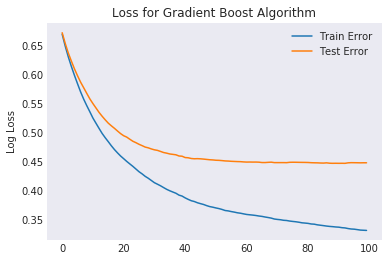

In [152]:
# plot the training and test error over the course of learning
plt.plot(error.index.values, error['Train'], label = 'Train Error')
plt.plot(error.index.values, error['Test'], label = 'Test Error')
plt.legend()
plt.ylabel('Log Loss')
plt.title('Loss for Gradient Boost Algorithm')

### Section 3: EDA and Data Gathering - Click Through Rate Dataset from Criteo

Below we download and unpack the dataset

In [1]:
# !curl -L -o criteo.tar.gz https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4364M  100 4364M    0     0  3123k      0  0:23:50  0:23:50 --:--:-- 2694k


In [1]:
# !mkdir -p data
# !tar -xvzf criteo.tar.gz -C ./data

tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
readme.txt
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
test.txt
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
train.txt
tar: train.txt: Cannot close: Input/output error
tar: Exiting with failure status due to previous errors


We begin by inspecting some of the files and getting basic stats (length of full training file) using the command line.

In [15]:
TRAIN_FILE="./data/train.txt"

print("First line: \n")
!head -n 5 $TRAIN_FILE

print("\nNumber of columns: ")
!head -n 1 $TRAIN_FILE | wc -w

print("\nNumber of rows: ")
!wc -l < $TRAIN_FILE

First line: 

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	

As described on the Kaggle competition site, there are a total of 13 integer feature columns, 26 hash string feature columns and one target variable (whether or not an add was clicked). As can be seen above, the number of columns does not match expected (13 + 26 + 1 = 40 vs 38). This discrepency is due to missing data and is something we will need to explore and properly handle when building trees. 
Below we proceed with the EDA by creating RDDs from the parsed input files and _cache_ them so that the parsing has to occur only once.

In [3]:
# imports
from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions

# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

# create RDDs
fullRDD = sc.textFile("./data/train.txt")
testRDD = sc.textFile("./data/test.txt")
toyRDD = sc.textFile('./data/toy_train.txt')

In [1]:
def parse_feature(line):
    fields = line.split("\t")
    label, features = int(fields[0]), fields[1:]
        # remove empty features introduced by extra tabs
    return (features[i], 1)

def parse_empty(line):
    fields = line.split("\t")
    label, features = int(fields[0]), fields[1:]
        # remove empty features introduced by extra tabs
    if features[i] == '':
        yield (1, 1)
        
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append('null')
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [4]:
trainRDDCached = trainRDD.map(parse).cache()
testRDDCached = testRDD.map(parse).cache()
toyRDDCached = toyRDD.map(parse).map(edit_data_types).cache()

We would expect there to be a class imbalance with many more unclicked ads than clicked ads, but let's see how extreme it is. We can perform this counting with a _map_ operation that emits the value of the label and a count of 1 and a _reduce_ operation that sums the count. 

In [12]:
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == '0').count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == '1').count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


__Toy Dataset for Manipulation in Pandas__

Below we utilize a toy dataset to show correlation plots and other plots inside of the pandas data structure. Following this brief analysis of the toy dataset - we will conduct EDA on the full dataset using Spark. 

In [25]:
# helper function 'null' to np.nan for pandas df for ebtter processing
def null_to_nan(line):
    """
    converts "null" to np.nan in RDD
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == 'null':
            formated_features.append(np.nan)
        else:
            formated_features.append(value)
    return (formated_features, label)

# put the toy RDD into a pandas dataframe for EDA charting
trainRDDtoPandas = toyRDDCached.map(null_to_nan) \
                                .map(lambda x: np.append(x[0], [x[1]])) \
                                .collect()

# MAKING columns into integers and categories groups
FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

toy_df = pd.DataFrame(trainRDDtoPandas, columns=FIELDS)

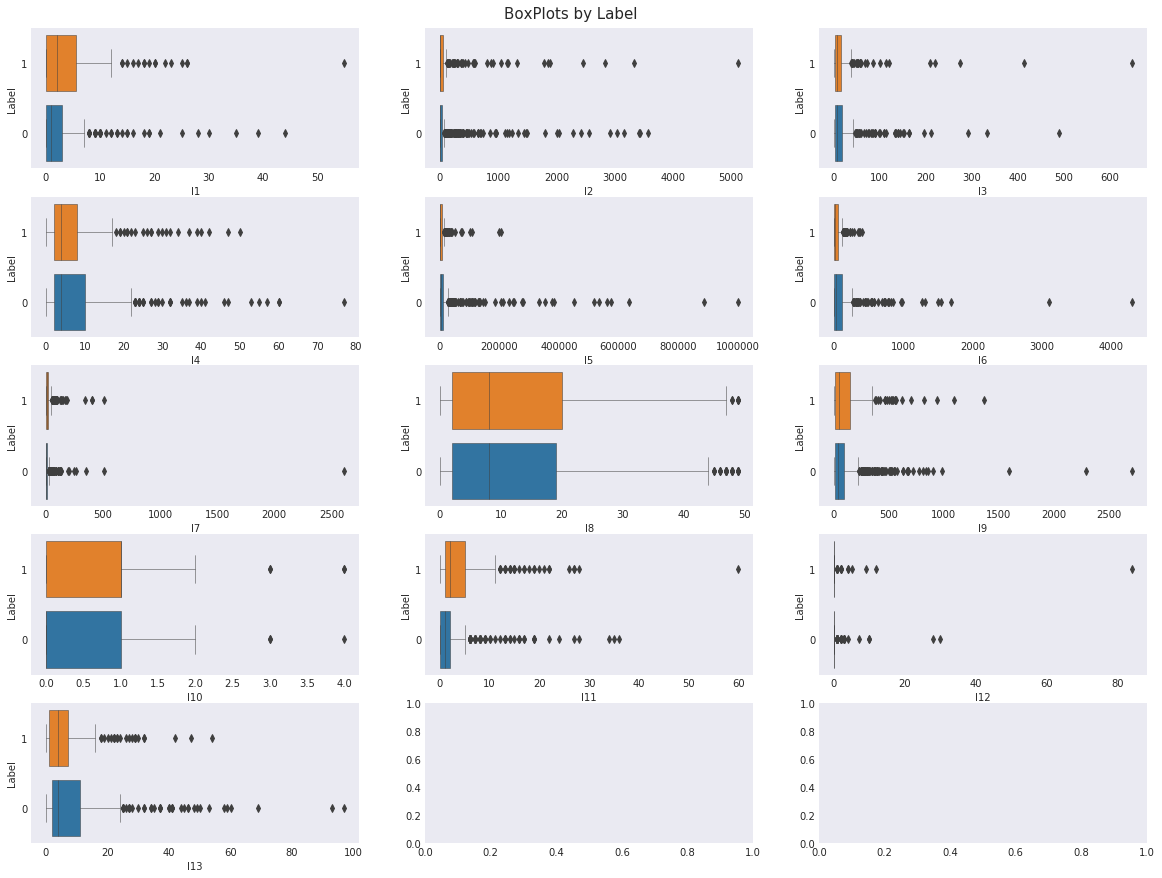

In [34]:
# plot boxplots of each feature vs. the target
fig, ax_grid = plt.subplots(5, 3, figsize=(15,10))
y = toy_df['Label']
for idx, feature in enumerate(num_columns):
    x = toy_df_num[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

The above results show that most of the features are skewed and have outliers on the right end. This also implies if we are imputing value for null, we should use median instead of mean. Also from the boxpot, we can see that many features have similar distribution for both target = 0 and target = 1, meaning that these features may not yield much information in estimating click rate. For this reason looking at variable interaction can further separate out the distribution of target = 0 or 1 datapoints. The idea behind decision trees is filter down several decision points in order to create teh most pure pools of datapoints. In this manner, we hope there will be a more seperable target variable distribution given a series of decisions to refine the dataset pool. 

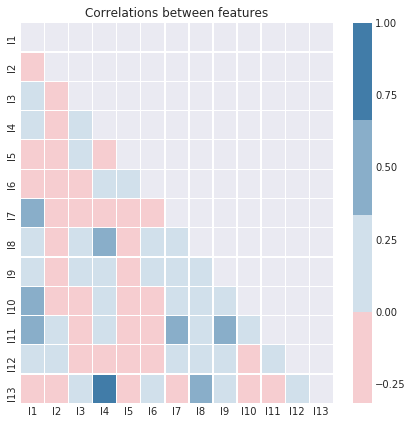

In [35]:
# Correlation between numerical features
corr = toy_df_num.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

We can see that some of the integer variables do appear to be highly correlated with one another. In the context of machine learning, features that are highly correlated should be removed or regularized with Lasso or Ridge as they don't give extra information. In our analysis we will retain all features and allow the gradient boosting algorithm to interpret split points - however further analysis given the context of the features/variables may prove beneficial to limit those variables that are highly correlated. 

__EDA on Full Training Dataset via Spark__

We are interested in better understanding the full training data. From published papers we know that many of the CTR datasets can be sparse - both in terms of zero value features as well as missing data. Having a better understanding of the distribution of individual features - along with missing values and unique values per feature will benefit our understanding of the dataset and allow methodologies to feature engineer the dataset.

In [ ]:
# Imports some more packages for the df EDA part
from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions
import pyspark.sql.functions as func
from pyspark.sql.functions import col, countDistinct, approxCountDistinct, count, when, desc
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.functions import *

trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()
trainDF = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).map(lambda x: x.tolist()).toDF(FIELDS).cache()

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']
NUM_FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']
CAT_FIELDS = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
              'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


trainDF = trainDF.withColumn("I1", trainDF.I1.cast('float'))
trainDF = trainDF.withColumn("I2", trainDF.I2.cast('float'))
trainDF = trainDF.withColumn("I3", trainDF.I3.cast('float'))
trainDF = trainDF.withColumn("I4", trainDF.I4.cast('float'))
trainDF = trainDF.withColumn("I5", trainDF.I5.cast('float'))
trainDF = trainDF.withColumn("I6", trainDF.I6.cast('float'))
trainDF = trainDF.withColumn("I7", trainDF.I7.cast('float'))
trainDF = trainDF.withColumn("I8", trainDF.I8.cast('float'))
trainDF = trainDF.withColumn("I9", trainDF.I9.cast('float'))
trainDF = trainDF.withColumn("I10", trainDF.I10.cast('float'))
trainDF = trainDF.withColumn("I11", trainDF.I11.cast('float'))
trainDF = trainDF.withColumn("I12", trainDF.I12.cast('float'))
trainDF = trainDF.withColumn("I13", trainDF.I13.cast('float'))

# Also chaging taregt to int
trainDF = trainDF.withColumn("Label", trainDF.Label.cast('int')).cache()

In [144]:
start = time.time()

# Keep a dictionary of high and low features
high_features = dict()
medium_features =  dict()

# total row count
row_count = trainDF.count()

for field in CAT_FIELDS:
    print("\nFOR COLUMN "+field+":")
    
    columnDF = trainDF[[field]].cache()
    
    # geting the missing counts
    missing_count = columnDF.select(count(when(col(field) == "null", 1))).head()[0]
    print("No. of Missing Values:", missing_count)
    
    # give the percentage of missing ones
    print("Percentage of Missing values:", np.round(missing_count*100/row_count, 2), "%")
    
    # Distinct
    distinct = columnDF.agg(approxCountDistinct(col(field)).alias(field)).head()[0]
    if missing_count != 0:
        distinct = distinct -1
    print("No. of Distinct Features (without null):", distinct)
    
    # Frequent Items 
    freq20 = columnDF.stat.freqItems([field], 0.1).head()[0]
    freq2 = columnDF.stat.freqItems([field], 0.02).head()[0]
    freq2 = list(set(freq2) - set(freq20))
    print("20% Occuring Features:", freq20)
    print("2% Occuring Features:", freq2)
    
    high_features[field] = freq20
    medium_features[field] =  freq2

print(f'\n... {time.time() - start} seconds.')


FOR COLUMN C1:
No. of Missing Values: 0
Percentage of Missing values: 0.0 %
No. of Distinct Features (without null): 1513
20% Occuring Features: ['be589b51', '87552397', '8cf07265', '05db9164', 'f473b8dc', '68fd1e64', '5a9ed9b0', '5bfa8ab5', '39af2607']
2% Occuring Features: ['291b7ba2', '24eda356', '28e55712', '41edac3d', '88abfaf6', '489d0f96', 'da4eff0f', 'd4b08d58', '09ca0b81', '287e684f', '7e5c2ff4', '65aada8c', '75ac2fe6', '9a89b36c', '9684fd4d', 'c71ae391', '6062d843', '2d4ea12b', '6ca3af46', 'fb174e6b', '3c9d8785', '7382c353', '439a44a4', '49807078', '340c148e', '98237733', '241546e0', '46300ee3', 'b455c6d7', 'bfb430af', 'fbc55dae', 'cd3695ae', '17f69355', '1464facd', 'f434fac1', 'e8ef605b', 'ae82ea21']

FOR COLUMN C2:
No. of Missing Values: 0
Percentage of Missing values: 0.0 %
No. of Distinct Features (without null): 564
20% Occuring Features: ['38a947a1', '287130e0', '2c16a946', '38d50e09', '1cfdf714', '09e68b86', '80e26c9b', '207b2d81', '4f25e98b', '8084ee93']
2% Occuring 

From the print-out of the categorical feature statistics we can infer a number of aspects regarding our dataset that will be challenging from a machine learning perspective: 
 - Large number of unique values per feature. In some cases there are more than 10 million unique values in an individual feature. As these variables are categorical we can either use one-hot encoding or binning prior to fitting our decision trees. The values in these categories have been anonymized via a hash function - meaning we cannot interpret the category value. This may inhibit the binning process as it may not be accurate to bin based on hash value. For future work given an understanding of the underlying values of the features we could proceed with binning to reduce the number of unique values in any individual feature. For this paper we will retain features that have fewer than 20 unique values - in the future we could use a binning approach to retain these categories with many unique values.
 - Many categories have a large degree of missing values (up to 44%). When training a decision tree the dataset must be complete - meaning we will either need to dramatically reduce the size of our training set - which will have a negative effect on accuracy performance, or we will need to fill in this value. Given that we are focusing on a one-hot encoding feature, rather than binning given the dataset knowledge. In Spark 2.4 we are able to retain NAN values in the training set and Spark will infer a direction of traverse in the tree. Given our understanding of the distribution of integer features in the plot above it may be more accurate to fill in missing values for the integer features as the column median rather than allowing Spark to infer how to handle.
 - We can see that there are relatively few values in a given feature that show up in more than 2% of the feature space. This means that many unique values likely only have a few repeated instances - supporting the notion that binning may be beneficial. An alternative binning approach would be to retain the x most frequent feature values (x could be 5 or 10 for instance) and bin the remaining features in a catch-all bin. Since the information gain on a unique feature that is only observed once in the dataset with either promote over-training or more likely won't yield any information gain - this approach may be beneficial.

In [148]:
# Numerical summary for I1~I13
start = time.time()

numeric_DF = trainDF[[NUM_FIELDS]].cache()
numeric_summaryDF= numeric_DF.describe()

# Numerical value
for field in NUM_FIELDS:
   numeric_summaryDF = numeric_summaryDF.withColumn(field, func.round(numeric_summaryDF[field], 2))

# Display numeric summary stats
numeric_summaryDF[['summary']+NUM_FIELDS[0:6]].show()
numeric_summaryDF[[NUM_FIELDS[6:]]].show()

print(f'\n... {time.time() - start} seconds.')

+-------+-----------+-----------+----------+-----------+-----------+-----------+
|summary|         I1|         I2|        I3|         I4|         I5|         I6|
+-------+-----------+-----------+----------+-----------+-----------+-----------+
|  count|2.5047061E7|4.5840617E7|3.600117E7|3.5903248E7|  4.46575E7|3.5588289E7|
|   mean|        3.5|     105.85|     26.91|       7.32|   18538.99|     116.06|
| stddev|       9.43|     391.46|    397.97|       8.79|    69394.6|     382.57|
|    min|        0.0|       -3.0|       0.0|        0.0|        0.0|        0.0|
|    max|     5775.0|   257675.0|   65535.0|      969.0|2.3159456E7|   431037.0|
+-------+-----------+-----------+----------+-----------+-----------+-----------+

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|         I7|         I8|         I9|        I10|        I11|        I12|        I13|
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|4.3857751E7

From the printout of the integer features we can observe that there is a large variation in the range and values for each of the features. Decision Tree's aren't prone to uneven feature ranges - so regularizing between 0 and 1 isn't necessary. As noted previously in the box-plot and observed on the summary statistics here representing the entire Training dataset - there appears to be a number of outlier variables. For instance in the I1 feature, the mean and standard deviation are 3.5 and 9.4 respectively but the maximum value is 5775. When inferring a NAN value - it may therefore be beneficial to infer the median of these features rather than 0 or another value. 

Text(0.5,0.98,'Histogram by Variable')

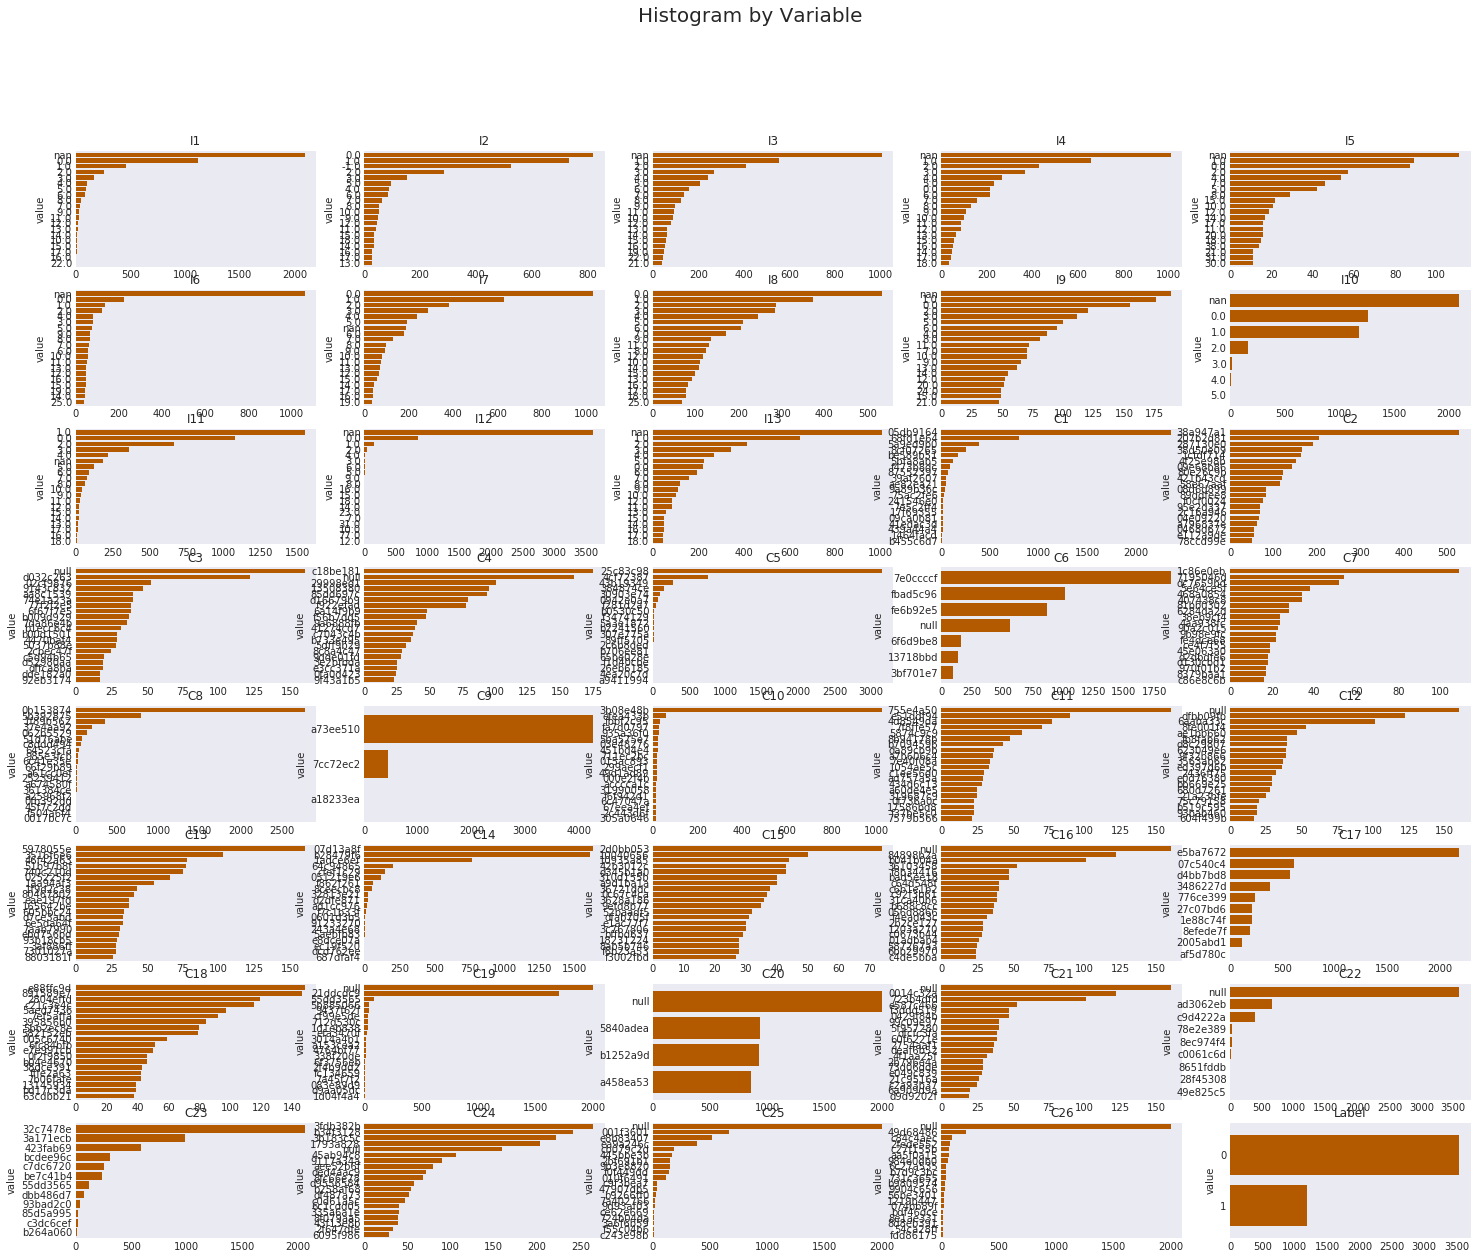

In [38]:
# Plot histogram of 20 most frequent values per feature    
fig, ax_grid = plt.subplots(8, 5, figsize=(25,20))
for ax, cat in zip(ax_grid.flat, FIELDS):
    category  = trainDF.select(cat).groupBy(cat).count().collect()
    c = [item[0] for item in category]
    count = [item[1] for item in category]
    category = {"value" : c, "count": count}
    category = pd.DataFrame(category)
    category = category.sort_values(by = "count", ascending  = False)
    category = category.iloc[:20]
    category.plot(kind = "barh", color = "#b35900", width = 0.8,
                                   x = "value", y = "count", title = cat, legend = False, ax = ax).invert_yaxis()
fig.suptitle('Histogram by Variable', fontsize = 20)

The plots above confirm our intution stated previously - that even though many features have a large number of unique values - there tends to be few unique values that show up frequently and the remaining only show up a handful or times. This confirms that we could follow with our approach of binning these low frequency counts to a catch-all bin as there likely isn't much information gain from these values. We instead defined to keep features which has fewer than 20 unique values. The premise of this is for simplicity, as well as to limit the size of our feature space given the data anonymity. By keeping features with fewer than 20 unique values, we expect to retain those features that have the highest information gain per value and will hopefully allow the decision tree to separate data records into pure sets given the target variable. 

As previously noted we have an approximate 1:4 split on no-click vs click examples (target variable). This creates a baseline accuracy of approximately 25% given the dataset. Discussed in the results section we may want to reweight our training examples to approximate a 1:1 split in order to better infer information about click = 1 data. We will leave this to future work as well.

### Section 4 - Algorithm Implementation

In this section we build a gradient-boosted decision tree using Spark ML. The spark implementation follows the Friedman algorithm routine previously discussed in section 2. The documentation, along with a link to the API, can be found here: https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier.

A lengthier tutorial for building pipelines and models using Spark can be found here: https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa. That tutorial borrows from another notebook located here: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html.

Because Gradient Boost is a sequential model (need tree_1 to compute tree_2) it is not as prone to parallel implementation as random forests are. In the Spark implementation the individual tree building tasks are parallelized. This notion causes the training times in Gradient Boost to exceed those of Random Forest. Parallelizing individual tree building in Spark follows the PLANET model as outlined by Google [Panda, B., Herbach, J., Basu, S., & Bayardo, R. (2009). PLANET: Massively Parallel Learning of Tree Ensembles with MapReduce. Lyon: ACM.]. This technique uses a central controller that provides the tree structure and decides on the optimum split given the information gain from various split points. As detailed in section 2, tree learning is a greedy algorithm in which all split points across all variables must be considered to determine the optimum split (Brieman's technique aids in this greedy approach slightly for unordered variables). It is at this step that parallel processing can help in order to analyze all potential splits and determine the best. Listed below is a detail of the map and reduce phase broken up by ordered or unordered variables. 

Controller: The controller lies outside of a map-reduce job and keeps track of the overall tree structure, along with the training set for each node (to compute the split decision) and the size of the splits. The controller proceeds throughout the training set calling map-reduce jobs at each node in order to find the most viable split point

Map Phase: 
 - Ordered lists: From before we know that we need to split at every point along an ordered list in order to find the true optimum split point. Because MapReduce breaks up the input data - it isn't possible to assess where the split point lies. Therefore PLANET simplifies the process slightly by (prior to the distributed job) computing equi-distant histogram for every ordered feature. The splits are then taken at the histogram buckets. While there is a tradeoff using this approach for absolute best split point - the computational cost savings are generally worth it. The map phase then splits at each feature and each value and emits a key, value pair of the form ((node, feature, split point), (sum of y values, sum of squared y values, total length that have value less than s)). 
 - Unordered lists: The map phase outputs key, value pairs of the form ((node, feature), (value, ((sum of y values, sum of squared y values, total length that have value less than s))). The key difference between these two scenarios is that the split value is located in the value for unordered lists and in the key for ordered lists. This falls back to Brieman's technique and requiring unordered lists to be sorted by y value to determine split points. 
 - The aggregated tuple (sum of y values, sum of squared y values, total length that have value less than s) is also output with a key value of node in order for the reducer phase to compare information gain on the various splits
 
Reduce Phase: 
 - The reducer is split into a series of summations based on the key value format: node, (node, feature), (node, feature, split point). Based on this data it then sums over the aggregated tuple format emitted in all three scenarios in order to determine the optimum split point
 - The output of the reducer is the best split it has seen for each node. This information along with the average y value and size of left and right branches is emited to the controller to further build the tree structure
 
Mentioned above, for Gradient Boosted Trees Frieman recommended a technique he called TreeBoost in which each leaf was given a different optimum constant update, rather than an average for the overall tree [Friedman, J. (1999). Greedy Function Approximation: A Gradient Boosting Machine. Stanford: Stanford University.]. In the current Spark GradientBoost algorithm, this approach is not utilized and a single parameter is used for the entire tree structure. Implementing TreeBoost is likely to improve overall model accuracy and is saved for a later step. 

Below we utilize the Spark ML library in order to fit a gradient boosted tree on the CLR dataset. 

#### Preprocessing

First, we import the modules we'll need and read the data into a dataframe.

In [10]:
import pyspark.sql.functions

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

ON_CLUSTER = True # flag to determine whether to read from a GCP bucket

In [11]:
if ON_CLUSTER:
    df = spark.read.csv("gs://w61-ucb2/data/train.txt", sep="\t", inferSchema=True)
else:
    df = spark.read.csv("./data/train.txt", sep="\t", inferSchema=True)
    
    # create a small sample for local work
    df = df.sample(False, .0001, 42)

Next, we need to transform the data into a format suitable for a GBTClassifier. We'll do this by creating a pipeline of transformations.

In [12]:
stages = [] # the stages in the pipeline

We first convert the categorical features into one-hot encoded vectors. However, as we saw in the EDA above, some features have many millions of unique values. It is infeasible to one-hot encode all of these due to memory constraints, and these features would likely make for poor split points in any case. Thus, we'll initially use only the categorical features that have fewer than 32 unique values, which is the default number of maximum bins used by the GBTClassifier.

In [13]:
categoricalColumns = [f"_c{i}" for i in range(14, 40)]
countsByCol = []

# get approximate distinct counts for each of the categorical features
for col in categoricalColumns:
    cnt = df.agg(
        pyspark.sql.functions.approx_count_distinct(df[col]).alias(col)
    ).collect()
    
    # store the columns name and the count
    countsByCol.append( (col, cnt[0][col]) )

The above results showed that most of the features are pretty much skewed and have outliers on the right end. This also implies if we are imputing value for null, we should use median instead of mean. Also from the boxpot, we can see the features are not super obvious in terms of predicting 1/0 as the orange and blue bar looks pretty similar

In [14]:
# get features that have fewer than 32 unique values
categoricalColumnsToEncode = [t[0] for t in countsByCol if t[1] < 32]
categoricalColumnsToEncode

['_c19', '_c22', '_c27', '_c30', '_c33', '_c35', '_c36']

Since all of these boxes are red or blue , it seems that some of the numerical variables are highly correlated with each other. In the context of Logistic Regression, features that are highly correlated should be removed or regularized with Lasso or Ride as they don't give extra information

In [15]:
# encode the subset of categorical columns
for categoricalCol in categoricalColumnsToEncode:
    
    # index the categories
    stringIndexer = StringIndexer(
        inputCol = categoricalCol, 
        outputCol = categoricalCol + "Index",
        handleInvalid="keep"
    )
    
    # convert the indices into binary SparseVectors
    encoder = OneHotEncoderEstimator(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    
    # add the stage
    stages += [stringIndexer, encoder]

We then combine the categorical and numeric columns into a feature vector.

In [16]:
# extract the encoded categorical features from the dataframe 
# and combine with the continuous features
features = [c + "classVec" for c in categoricalColumnsToEncode] + \
                [f"_c{i}" for i in range(1, 14)]

# create the feature vector, preserving rows that contain missing data.
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="features", 
    handleInvalid="keep"
)

# add the assembler to the stages of the pipeline
stages += [assembler]

Finally, we convert the dataset labels into label indices.

In [17]:
# convert label into indices
labelIndexer = StringIndexer(inputCol="_c0", outputCol="label")
stages += [labelIndexer]

All of the transformations that we need to perform to build a GBT now exist as stages, which we'll next evaluate in a pipeline.

In [18]:
preppedDF = (
    Pipeline()
    .setStages(stages)
    .fit(df)
    .transform(df)
)

#### Initial GBT model

We'll next perform a single split of the data into training and test sets, fit a GBT to the training data using the default parameters and evaluate the performance on the test data.

In [19]:
# split the data
trainData, testData = preppedDF.randomSplit([0.75, 0.25], seed = 42)

# create and train the classifier
gbtModel = GBTClassifier().fit(trainData)

# make predictions on the test data
predictions = gbtModel.transform(testData)

In order to compare this initial model to future iterations, get the AUROC score.

In [49]:
# get the auroc for the default model
evaluator = BinaryClassificationEvaluator(labelCol="label")
auroc = evaluator.evaluate(predictions, { evaluator.metricName: "areaUnderROC" })
print(f"Test Area Under ROC: {auroc}")

Test Area Under ROC: 0.7073676650780636


We'll also create a function to give a better sense of the model's performance.

In [21]:
def get_counts(predictions):
    """ Get the counts of label and prediction agreement """
    
    # split the dataframe into correct and incorrect predictions
    correct = predictions.filter(predictions.label == predictions.prediction)
    incorrect = predictions.filter(predictions.label != predictions.prediction)

    # get the various counts needed to calculate metrics
    true_positives_cnt = correct.filter(correct.label == 1).count()
    true_negatives_cnt = correct.filter(correct.label == 0).count()
    false_positives_cnt = incorrect.filter(incorrect.label == 0).count()
    false_negatives_cnt = incorrect.filter(incorrect.label == 1).count()

    return true_positives_cnt, true_negatives_cnt, false_positives_cnt, false_negatives_cnt

def get_scores(predictions):
    """ Get the evaluation scores """

    tp, tn, fp, fn = get_counts(predictions)
    
    # calculate the metrics 
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp)

    recall = tp / (tp + fn)

    f1_score = 2 * (recall * precision) / (recall + precision)
    
    return accuracy, precision, recall, f1_score
    
def print_eval_metrics(predictions):
    """ Print performance metrics.
    
        Args:
            predictions - a DataFrame with model predictions
    """
    
    accuracy, precision, recall, f1_score = get_scores(predictions)

    # print the results
    print(f"Test accuracy: {round(accuracy, 3)}")
    print(f"Test precision: {round(precision, 3)}")
    print(f"Test recall: {round(recall, 3)}")
    print(f"Test F1 score: {round(f1_score, 3)}")

In [48]:
print_eval_metrics(predictions)

Test accuracy: 0.76
Test precision: 0.598
Test recall: 0.191
Test F1 score: 0.289


From our EDA section, we highlighted that our dataset had 74% of the examples in the negative click class (Label = 0). Here we can see our accuracy (TP + TN) / # Examples is only marginally improved from the baseline. It is possible that our decision tree is being affected by the dispraportionate training class and re-weighting the training examples could improve the models ability to predict the positive class. We can see that our recall (TP / (TP + FN)) is fairly low, meaning that there are many times when the actual result is a click but our model predicts no-click. 

Our precision (TP / (TP + FP)) is decent given the models lack of performance in predicting a click and tendency to predict no click. 

For the problem (CTR) we would prefer to have our F1 score as higher as possible - since this takes into account false positives and false negatives. We can see that there is still quite a bit of room for improvement in our current model as F1 is fairly low. 

In [97]:
gbtModel.save("gs://w61-ucb2/data/gbtModel")

__Gradient Boost Results and Discussion__

There are a number of potential issues with out initial model. First, although we used a random split to create the training and test sets, it is always possible with a single split that there will be anomalies that cause the two sets to differ in ways that cause us to misestimate the model's performance on the test data. To address this problem, we will use 3-fold cross validation below in order to evaluate the model using 3 different splits.

Second, it is possible that the default hyperparameters are not the best hyperparameters for this data. In particular, the model above trains 20 trees (maxIter), with a height of 5 or  $2^5=32$ maximum leaves (maxDepth), and uses a learning rate of 0.1. Below, we'll experiment with different permutations of these parameters and select the best model.

In [15]:
# specify the parameters over which to search
gbt = GBTClassifier()
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxIter, [10, 20, 30])
    .addGrid(gbt.maxDepth, [3, 5])
    .build()
)

In [16]:
# setup 3-fold cross-validation for each model
crossVal = CrossValidator(
    estimator=GBTClassifier(), 
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=3
)

Having initialized the objects we need, we train the models and select the one with the highest score.

In [17]:
cvModel = crossVal.fit(trainData)

In [18]:
predictions = cvModel.transform(testData)

In order to compare this initial model to future iterations, get the AUROC score.

In [21]:
print_eval_metrics(predictions)

Test accuracy: 0.761
Test precision: 0.603
Test recall: 0.196
Test F1 score: 0.296


In [19]:
evaluator.evaluate(predictions)

0.710653928067178

We see a slight improvement in the AUROC score ($0.710 - 0.707 = 0.003$), the test accuracy $(0.761 - 0.76 = 0.001)$ and the f1 score ($0.296 - 0.289 = 0.007$) with this model. Our model performance has improved by using cross validation and grid search. We still ahve a fairly low F1 and recall score however across these different models. After this section we will detail methods for future work in order to improve these statistics. 

Reflecting on what these values mean in the problem of CTR. Given a web-ad slot and a broker that needs to select an appropriate ad to maximize the revenue - our precision score (reflecting the subsamples where our model predicts Label = 1) is fairly decent. So given the examples of potential ads, our algorithm does tend to do ok predicting whether or not it'll be clicked. We do have a cost associated with potential lost higher revenue from an ad that in acutality had Label = 1 but our model predicted Label = 0 due to the low recall statistics. 

We'll now inspect the parameters that correspond to the best model.

In [47]:
bestModel = cvModel.bestModel
param_map = bestModel.extractParamMap()
num_trees = param_map[bestModel.getParam("maxIter")]
max_depth = param_map[bestModel.getParam("maxDepth")]

print(f"Number of trees: {num_trees}")
print(f"Maximum height of tree: {max_depth}")

Number of trees: 20
Maximum height of tree: 5


We see that the maximum depth of the tree is 5 and the number of iterations (i.e. the height of the tree) is 20. The results indicate that adding more trees resulted in overfitting the model for this dataset. The parameters for the best model in fact match those used in the default model above, so the improved scores are actually a result of using cross-validation.

In [22]:
# save the model for future use
cvModel.bestModel.save('gs://w61-ucb2/data/gbtModelBest')

__Methods to Implement in Future Work__

Gradient boost techniques are a very popular machine learning implementation and have observed very good results in some of the data science competition sites. There has therefore been a number of improvements and iterations on the gradient boost techniques presented here that could aid in the development of a more accurate gradient boost model: 
 - Handling of sparse data / matrix: As shown in the EDA section and as generally accepted with CTR data, many of the features are sparse (empty) or missing (NAN). When building a decision tree, we use an encoding routine to separate categorical features into n_unique features. This causes the feature space to get very large (especially when there are a number of categories as was the case in this dataset (1293 unique values in one feature space)). If a one-hot encoding routine is utilized this causes the feature space to become very sparse (number of zero values) as most datapoints won't contain any data. There is also the problem of training on NAN values which isn't possible. In this example we either: (a) imputed the mean of a numeric vector and used that to fill NAN values (b) assumed the value of zero for all missing data in categorical features. One common method for addressing the sparsity issue is to encode a category into a series of bins rather than one-hot encoding. In this CTR data our categorical features were hash values rather than the original dataset. Because of this, we did not choose to employ a binning technique as we were uncertain of the algorithm to create the hash and whether there was validity in binning values based on their hash value. Given another training set where we had access to the raw value and can bin by value this is a worthy technique. XG-Boost specifically handles sparse data well by performing what the authors entitled 'sparsity-aware split finding'. The basic premise used in XG-boost is to utilize a default direction when encountering NAN or zero values for a particular feature. This default direction is determined by analyzing all missing values for that feature and determining the most appropriate direction [Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Cornell University.]. 
 - Alternatives to One-Hot-Encoding: We've already mentioned the potential to use binning rather than one-hot encoding. Another popular technique is to use a target statistic - such as the expected value of the output parameter based on the category value or alternatively for the bin. The technique is similar to binning except the value is replaced with a target statistic. There are a number of alternative methods to compute the target statistic that have been utilized to optimize training and prevent target leakage [Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A. V., & Gulin, A. (2019). CatBoost: unbiased boosting with categorical features.]. 
 - TreeBoost: As mentioned prior to implementing gradient boost in Spark. The current library doesn't make use of separate multiplier values for each leaf node as recommended by Friedman. Implementing TreeBoost has been shown to increase the accuracy of gradient boost models 
 - Individual Tree Optimization: Gradient boost relies on a number of weak estimators to create a good prediction in aggregate. There are a number of methods we can employ to allow our weak estimator to more accurately assess each problem and therefore optimize the ensemble: 
     - Depth of the trees: This can lead to overfitting but can also improve individual prediction which can benefit the aggregate model
     - Minimum number of examples per leaf: Similar to depth of the tree, can lead to overfitting and or model improvement depending on the problem
 - Shrinkage: In the Spark ML implementation we chose a learning rate that tempered the adjustments made on sequential models fit to the residuals. We can further refine this value to optimize model performance
 - Regularization: Use L1 and L2 regularization techniques to penalize complex models. This is assessed in the loss functino by adding regularization terms to the end of the loss function corresponding to L1 and L2 regularization: $$L = loss function + \frac{1}{2} \lambda \sum w_j^2 + \alpha \sum |w_j|$$ Where $\lambda$ and $\alpha$ are the L2 and L1 regularization terms respectively. 

### Section 5: Application of Course Concepts

This project benefited from the use of library packages pre-developed for Spark distributed computing. While the implementation via Spark was pre-configured in this way, there were still numerous elements associated with classroom topics that assisted our progression in this final project. 

__Encoding & Feature Selection__

Click through rate data has the challenge of containing highly sparse data. As described in the EDA section of this notebook, we had a total of 38 features, each of these features contained a number of unique values (in some cases over 10 million unique values). We explored the option of using one-hot encoding of these featuresin order to treat them as input to our decision tree. The difficulty with this approach is the extent of the  matrix (require an algorithm design that is robust to sparse matrices) vs the information gain of encoding  features with many unique values. 

We then looked at and represented these features in alternative ways to one-hot encoding. In particular we discussed the benefits of binning certain features. The benefit of binning is our feature space is more reasonably contained, however we give up some information encoded in that feature by binning. Additionally, our categorical variables contained hash values. As we could not determine the hashing function, and didn't know what the variable represented in the first place, we could not properly determine a suitable binning technique. Given a dataset where we fully understood the features, we could establish more suitable bins to retain as much information as possible while limiting the input vector.

__Bias Variance Tradeoff__

In all machine learning algorithms, and particularly evident in decision trees - is the notion of a tradeoff between bias and variance. For decision trees, which are known to overfit for a single particular tree - there can be low bias and high variance due to this fact.  If trees are grown without stopping criteria and not appropriately tuned, we would essentially have a datapoint mapped to a particular predicted outcome. When we tested on a validation set, the datapoint would likely follow the tree structure and match exactly what a data point in the training set observed. The opposite is true of a stump (one split point) where there is low variance but high bias. The level of control over these parameters can be defined either by pruning a fully developed tree, or limiting the extent to which a tree can grow. Parameters such as max depth and minimum examples at leaf help to control the extent to which a tree is grown and therefore the bias / variance of a particular tree.

Gradient Boost has the benefit of reducing both the variance (by utilizing an ensemble of many trees) as well as the variance - random forest is restricted to reducing the variance only [Suen, Yuk Lai, et al. “Combining Bias and Variance Reduction Techniques for Regression Trees.” Machine Learning: ECML 2005 Lecture Notes in Computer Science, 2005, pp. 741–749., doi:10.1007/11564096_76.]. Gradient Boost achieves a reduction in bias by adding trees together in order to generate a 'reduction in bias by increasing the expressive power of the base learner'. Essentially the base learner (decision tree) can more accurately predict nuanced datapoints by having a sequential model.

One option for future work, we have discussed the notion of utilizing stochastic gradient boost - using a random subsample of data to prodcue the next tree. The premise behind this approahc is a reduction in the variance of the model further by ensuring trees are not correlated with one another. 

__Gradient Descent__

The algorithm we chose to utilize for predicting click through rate is called Gradient Boosted Trees - so it is obvious  that gradients play a factor in the algorithm design. As detailed in section 2 of this notebook, we utilize gradient descent when adding an additional tree to the model. 

In normal gradient descent we have a series of weights and a loss function. The derivative of the loss function is typically taken in order to determine the gradient and adjust the weights accordingly. In gradient boosted trees there aren't weights to adjust, instead we must adjust the parameters of the tree. In our algorithm design outlined in the GB section of section 2 of this notebook, we take the first derivative of the loss function given $y_i$ and the prediction $F_{m-1}(x_i) + \gamma h_m(x_i))$. This first derivative is therefore the gradient and is defined as a parameter to move in the direction of lower loss. As we add decision trees to our sequential model, we continue to step down the loss function in the direction of maximum descent.

